In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib widget

In [8]:
df = pd.read_excel('C:/Users/thiag/Phyton/amigo PID/amigo PID.xlsx', sheet_name='amigo PID',usecols='A:L')
df

,Tempo,PV_Vazao,SP_Vazao,MV_Potencia_Bomba,Histerese_Vazao,T in,T out,SP T out,MV Potencia,Histerese da Temperatura,PV Vazão Filtro,PV Temp Filtro
0,4093.99,0.00,0.0,0.0000,1,17.6,16.7,30,0,3,0.0,16.56
1,4094.24,0.00,0.0,0.0000,1,17.6,16.7,30,0,3,0.0,16.67
2,4094.49,0.00,0.0,0.0000,1,17.6,16.7,30,0,3,0.0,16.76
3,4094.75,0.00,0.0,0.0000,1,17.6,16.7,30,0,3,0.0,15.61
4,4095.00,0.00,0.0,0.0000,1,17.6,16.7,30,0,3,0.0,16.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2841,4807.12,1.20,1.0,0.2784,1,17.6,16.7,30,0,3,0.0,16.65
2842,4807.37,1.05,1.0,0.2784,1,17.6,16.7,30,0,3,0.0,16.65
2843,4807.62,0.92,1.0,0.2824,1,17.6,16.7,30,0,3,0.0,16.75
2844,4807.87,0.78,1.0,0.2863,1,17.6,16.7,30,0,3,0.0,16.98


In [15]:
df_plot=df[['Tempo','PV_Vazao','SP_Vazao','MV_Potencia_Bomba']].dropna() 
df_plot['Tempo']=df_plot['Tempo'].astype(float)
df_plot['PV_Vazao']=df_plot['PV_Vazao'].astype(float)
df_plot['SP_Vazao']=df_plot['SP_Vazao'].astype(float)
df_plot['MV_Potencia_Bomba']=df_plot['MV_Potencia_Bomba'].astype(float)
# Define os eixos
x = df_plot['Tempo']
y1 = df_plot[['PV_Vazao']]
y2 = df_plot[['SP_Vazao']]
y3 = df_plot[['MV_Potencia_Bomba']]

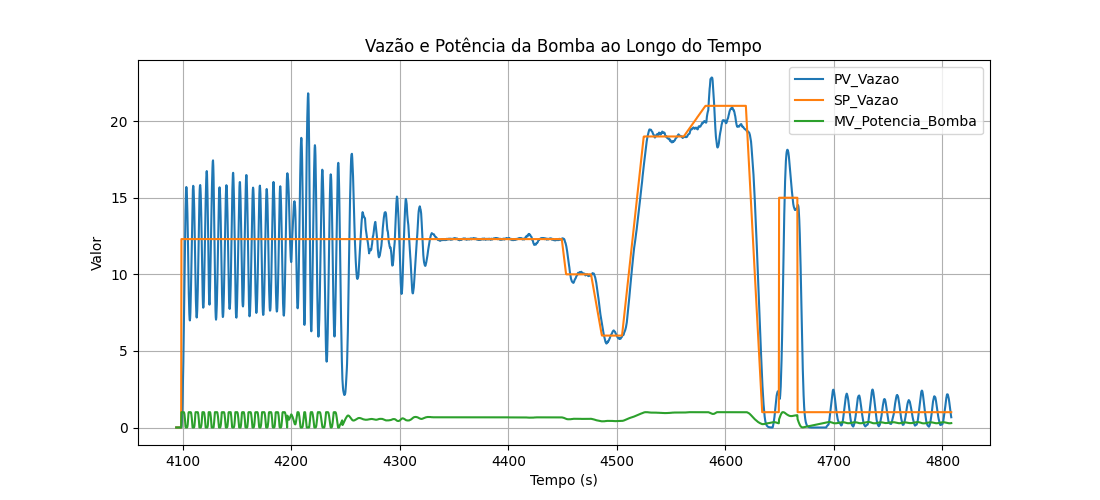

In [18]:
fig, ax = plt.subplots(figsize=(11, 5)) # Adicionado figsize diretamente na criação do subplot

# Plota cada linha individualmente, atribuindo um rótulo para a legenda
ax.plot(x, y1, label='PV_Vazao')
ax.plot(x, y2, label='SP_Vazao')
ax.plot(x, y3, label='MV_Potencia_Bomba')

ax.legend() # Exibe a legenda com os rótulos definidos acima
plt.xlabel('Tempo (s)')
plt.ylabel('Valor') # Adicione um rótulo para o eixo Y para clareza
plt.title('Vazão e Potência da Bomba ao Longo do Tempo') # Adicione um título ao gráfico
plt.grid(True) # Adiciona um grid para melhor visualização
plt.show()


--- Detalhes do Degrau Identificado ---
Tempo do Degrau (t_step): 4098.76
MV Inicial: 0.00
MV Final: 0.29
PV Inicial: 0.00
PV Final (Assumido): 0.67
Palpites Iniciais para [Kp, Tau, Theta]: [2.3402025847013626, 236.45333333333323, 70.93599999999996]

--- Parâmetros do Modelo FOPDT Estimados ---
Kp (Ganho do Processo): 36.2427
Tau (Constante de Tempo): 0.6602
Theta (Tempo Morto): 1.2100


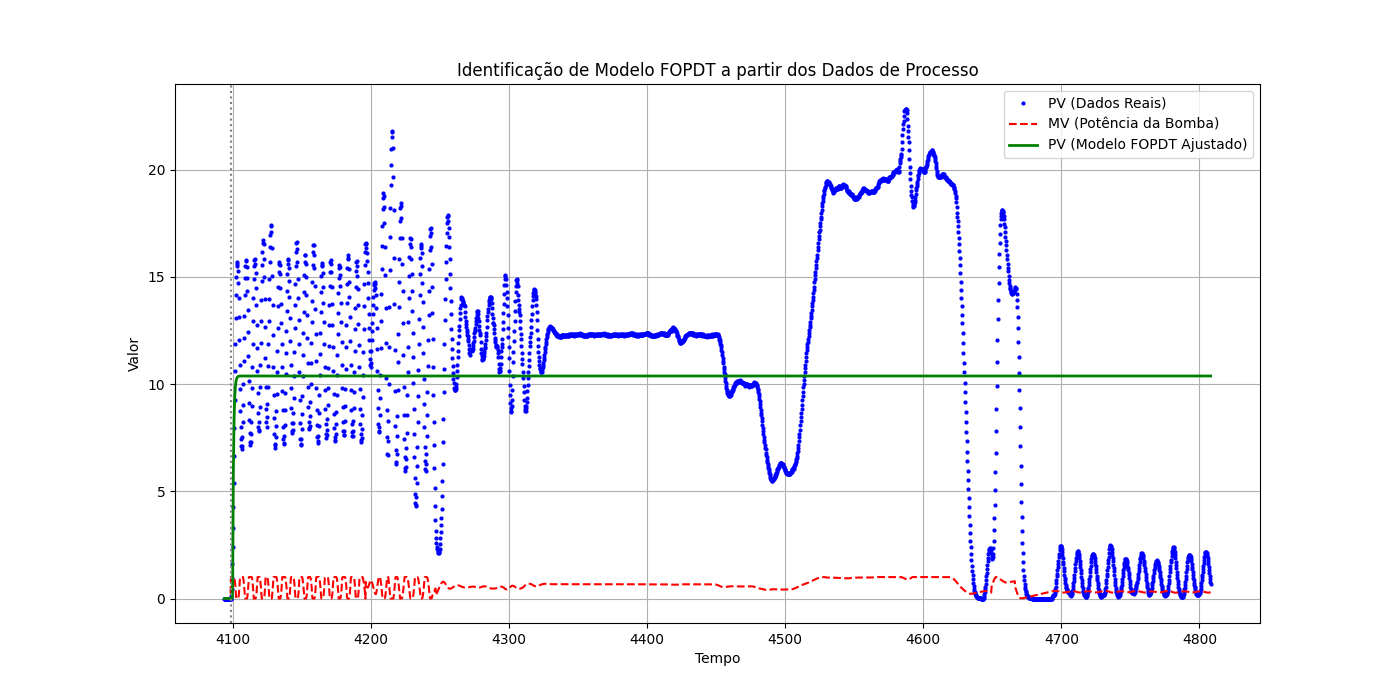

In [ ]:
# --- 1. Carregar e Preparar os Dados ---
# Seu código de carregamento e limpeza de dados
try:
    df = pd.read_excel('C:/Users/thiag/Phyton/amigo PID/amigo PID.xlsx', sheet_name='amigo PID', usecols='A:L')
    df_plot = df[['Tempo', 'PV_Vazao', 'SP_Vazao', 'MV_Potencia_Bomba']].dropna()

    # Garante que as colunas são numéricas (já está no seu código)
    df_plot['Tempo'] = df_plot['Tempo'].astype(float)
    df_plot['PV_Vazao'] = df_plot['PV_Vazao'].astype(float)
    df_plot['SP_Vazao'] = df_plot['SP_Vazao'].astype(float)
    df_plot['MV_Potencia_Bomba'] = df_plot['MV_Potencia_Bomba'].astype(float)

except FileNotFoundError:
    print("Erro: O arquivo 'amigo PID.xlsx' não foi encontrado no caminho especificado.")
    print("Por favor, verifique o caminho do arquivo e tente novamente.")
    exit()
except KeyError as e:
    print(f"Erro: Uma das colunas esperadas não foi encontrada no arquivo Excel: {e}")
    print("Verifique se os nomes das colunas 'Tempo', 'PV_Vazao', 'SP_Vazao', 'MV_Potencia_Bomba' estão corretos.")
    exit()
except Exception as e:
    print(f"Ocorreu um erro ao carregar ou processar o arquivo: {e}")
    exit()

# --- 2. Definir a Função do Modelo FOPDT ---
# Esta função calcula a resposta da PV para um dado degrau na MV, com Kp, tau e theta.
def fopdt_model(t, Kp, tau, theta, t_step, mv_initial, mv_final, pv_initial):
    """
    Calcula a resposta de um modelo FOPDT para um degrau.
    t: Array de tempo
    Kp: Ganho do processo
    tau: Constante de tempo
    theta: Tempo morto
    t_step: Tempo em que o degrau na MV ocorre
    mv_initial: Valor da MV antes do degrau
    mv_final: Valor da MV após o degrau
    pv_initial: Valor da PV no estado estacionário antes do degrau
    """
    delta_mv = mv_final - mv_initial
    response = np.zeros_like(t, dtype=float)

    # A resposta começa apenas após o tempo morto
    effective_t = t - (t_step + theta)

    # Aplica o modelo FOPDT apenas para tempos efetivos positivos
    mask = effective_t > 0
    response[mask] = pv_initial + Kp * delta_mv * (1 - np.exp(-effective_t[mask] / tau))

    # Antes do degrau e durante o tempo morto, PV permanece no valor inicial
    response[t < (t_step + theta)] = pv_initial

    return response

# --- 3. Identificar o Degrau na MV e os Valores Iniciais/Finais ---
# Este é um passo crucial. Precisamos detectar quando a MV mudou para identificar o degrau.
# Assumimos que o primeiro degrau significativo ocorre no início do dataset.
# Pode ser necessário ajustar esta lógica se seus dados tiverem múltiplos degraus ou ruído.

# Encontra o índice onde a MV_Potencia_Bomba muda pela primeira vez significativamente
# Usamos 0.01 como um pequeno limiar para evitar ruído.
mv_diff = np.abs(df_plot['MV_Potencia_Bomba'].diff())
idx_step_candidates = mv_diff[mv_diff > 0.01].index

if len(idx_step_candidates) == 0:
    print("Erro: Nenhuma mudança de degrau significativa detectada na 'MV_Potencia_Bomba'.")
    print("Certifique-se de que os dados contêm um teste de degrau em malha aberta.")
    exit()

idx_step = idx_step_candidates[0] # Pega o primeiro ponto de mudança
t_step = df_plot['Tempo'].iloc[idx_step]

# Valores da MV e PV antes e depois do degrau
mv_initial = df_plot['MV_Potencia_Bomba'].iloc[idx_step - 1] if idx_step > 0 else df_plot['MV_Potencia_Bomba'].iloc[0]
pv_initial = df_plot['PV_Vazao'].iloc[idx_step - 1] if idx_step > 0 else df_plot['PV_Vazao'].iloc[0]

# Tenta encontrar o valor final da MV, assumindo que ela estabiliza
mv_final = df_plot['MV_Potencia_Bomba'].iloc[-1]
# Tenta encontrar o valor final da PV, assumindo que ela estabiliza
pv_final = df_plot['PV_Vazao'].iloc[-1]

print(f"\n--- Detalhes do Degrau Identificado ---")
print(f"Tempo do Degrau (t_step): {t_step:.2f}")
print(f"MV Inicial: {mv_initial:.2f}")
print(f"MV Final: {mv_final:.2f}")
print(f"PV Inicial: {pv_initial:.2f}")
print(f"PV Final (Assumido): {pv_final:.2f}")

# --- 4. Preparar Função para Otimização (curve_fit) ---
# A função de ajuste deve ter os parâmetros a serem otimizados como primeiros argumentos.
# Os outros parâmetros do degrau são passados como 'args' para curve_fit.
def fopdt_fit_wrapper(t, Kp, tau, theta):
    return fopdt_model(t, Kp, tau, theta, t_step, mv_initial, mv_final, pv_initial)

# --- 5. Estimar Parâmetros Iniciais (Palpites) ---
# Um bom palpite inicial ajuda a otimização a convergir corretamente.
# Kp inicial: (Mudança na PV) / (Mudança na MV)
delta_pv = pv_final - pv_initial
delta_mv = mv_final - mv_initial

if delta_mv == 0:
    print("Erro: A 'MV_Potencia_Bomba' não variou. Não é possível identificar o processo.")
    exit()

initial_Kp_guess = delta_pv / delta_mv

# Estimativas para tau e theta podem ser mais complicadas.
# Um palpite comum para theta pode ser o tempo até a PV começar a se mover.
# Um palpite para tau pode ser uma fração da duração total do ensaio ou 
# o tempo para atingir 63.2% da mudança total após o tempo morto.
# Vamos usar valores genéricos, que podem precisar de ajuste dependendo do seu processo.
initial_tau_guess = (df_plot['Tempo'].max() - t_step) / 3 # Cerca de 1/3 do tempo restante
initial_theta_guess = (df_plot['Tempo'].max() - t_step) / 10 # Cerca de 1/10 do tempo restante

# Ajuste os palpites se parecerem irrealistas.
if initial_tau_guess <= 0: initial_tau_guess = 1.0
if initial_theta_guess < 0: initial_theta_guess = 0.1 # Theta pode ser muito pequeno mas não negativo

# Evitar zero para Kp inicial se a mudança for para zero (ex. 0.0001)
if abs(initial_Kp_guess) < 1e-6: initial_Kp_guess = 0.01 # Pequeno valor se for muito próximo de zero

initial_guesses = [initial_Kp_guess, initial_tau_guess, initial_theta_guess]
print(f"Palpites Iniciais para [Kp, Tau, Theta]: {initial_guesses}")


# --- 6. Realizar a Otimização para Encontrar Kp, Tau, Theta ---
try:
    # bounds define limites para os parâmetros (Kp, tau, theta).
    # Kp pode ser negativo (processo inverso), mas tau e theta devem ser positivos.
    popt, pcov = curve_fit(fopdt_fit_wrapper, df_plot['Tempo'], df_plot['PV_Vazao'],
                           p0=initial_guesses,
                           bounds=([-np.inf, 0.01, 0], [np.inf, np.inf, np.inf])) # tau e theta > 0

    Kp_estimated, tau_estimated, theta_estimated = popt

    print("\n--- Parâmetros do Modelo FOPDT Estimados ---")
    print(f"Kp (Ganho do Processo): {Kp_estimated:.4f}")
    print(f"Tau (Constante de Tempo): {tau_estimated:.4f}")
    print(f"Theta (Tempo Morto): {theta_estimated:.4f}")

    # --- 7. Visualizar os Resultados ---
    plt.figure(figsize=(14, 7))
    plt.plot(df_plot['Tempo'], df_plot['PV_Vazao'], 'b.', markersize=4, label='PV (Dados Reais)')
    plt.plot(df_plot['Tempo'], df_plot['MV_Potencia_Bomba'], 'r--', label='MV (Potência da Bomba)')

    # Gerar a resposta do modelo com os parâmetros estimados
    pv_model_fit = fopdt_fit_wrapper(df_plot['Tempo'], Kp_estimated, tau_estimated, theta_estimated)
    plt.plot(df_plot['Tempo'], pv_model_fit, 'g-', linewidth=2, label='PV (Modelo FOPDT Ajustado)')

    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.title('Identificação de Modelo FOPDT a partir dos Dados de Processo')
    plt.grid(True)
    plt.legend()
    plt.axvline(x=t_step, color='gray', linestyle=':', label='Início do Degrau MV')
    plt.show()

except RuntimeError as e:
    print(f"\nErro durante a otimização de curve_fit: {e}")
    print("Isso pode ocorrer se os dados não se ajustarem bem a um modelo FOPDT,")
    print("se os palpites iniciais forem ruins ou se não houver um degrau claro.")
    print("Tente ajustar os palpites iniciais (initial_guesses) ou inspecionar seus dados.")
except ValueError as e:
    print(f"\nErro nos valores ou limites de curve_fit: {e}")
    print("Verifique se seus dados PV_Vazao e MV_Potencia_Bomba são numéricos e têm variação suficiente.")